In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder containing JSON files
folder_path = "/workspace/datasets/apollo/car_models_json"

# List all JSON files in the folder
json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

#set seed for reproducibility
np.random.seed(0)

print("Number of JSON files found: ", len(json_files))

Number of JSON files found:  79


In [2]:
import sys 
sys.path.append("../utils")
from utils3d_model import display_point_clouds,display_meshes,load_point_clouds,load_meshes,chamfer_distance

In [3]:
# Load all point clouds
point_cloud_list, point_cloud_titles = load_point_clouds(folder_path, json_files,len(json_files))

/workspace/examples/../utils/utils3d_model.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


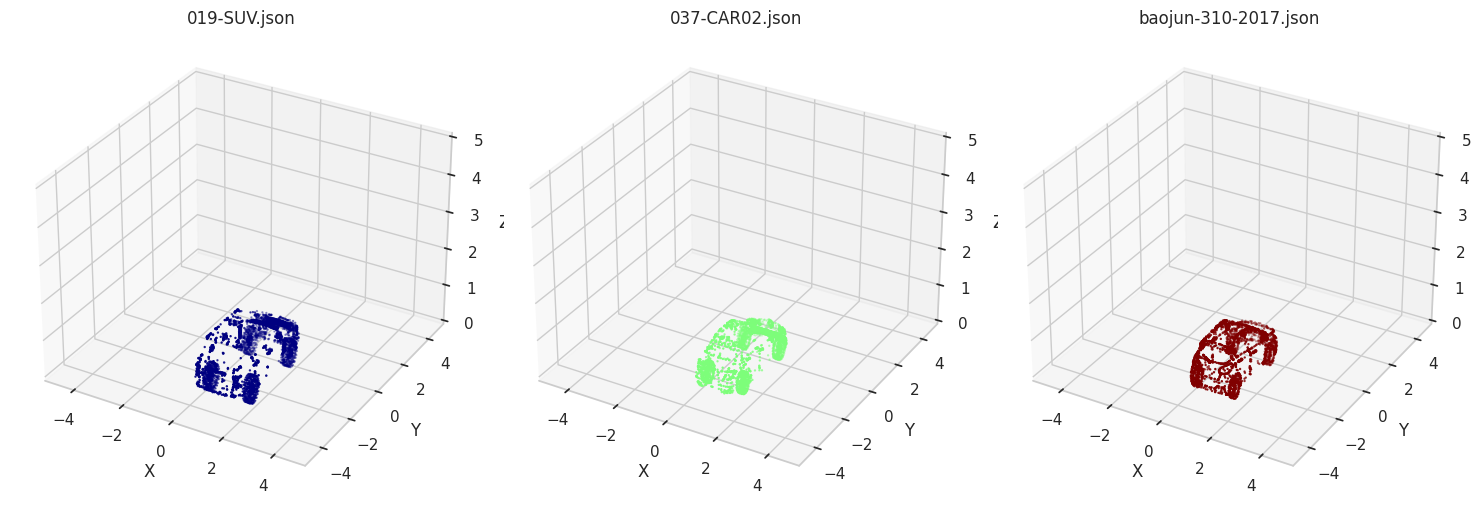

In [4]:
display_point_clouds([point_cloud_list["SUV"][0],point_cloud_list["3x"][0],point_cloud_list["2x"][0]], [point_cloud_titles["SUV"][0],point_cloud_titles["3x"][0],point_cloud_titles["2x"][0]])

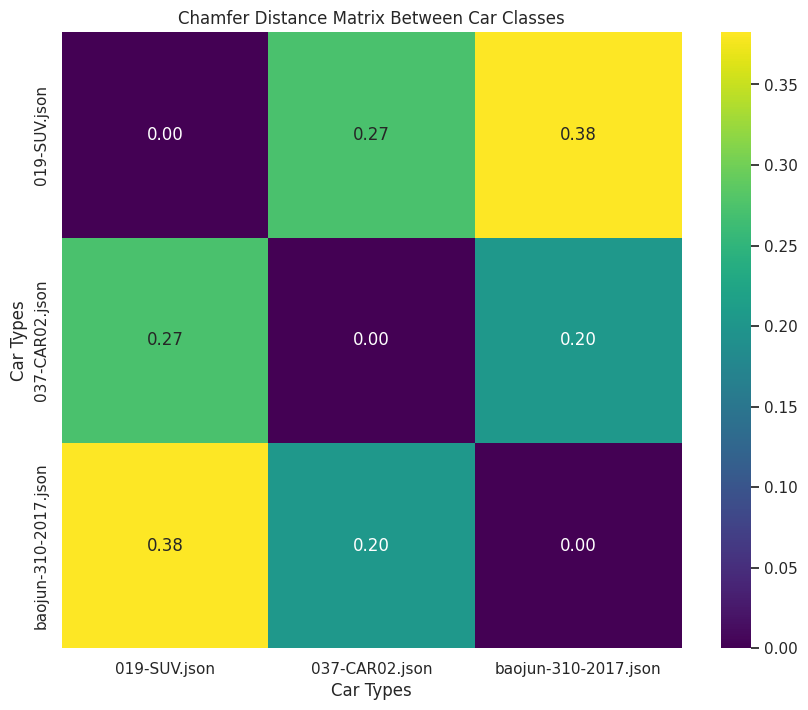

In [5]:
import seaborn as sns

# List of car types and their respective first car point cloud
car_types = ['SUV', '3x', '2x']
point_clouds = [point_cloud_list[car_type][0] for car_type in car_types]  # First car point cloud from each type
titles = [point_cloud_titles[car_type][0] for car_type in car_types]  # Titles for each car

# Calculate the Chamfer distance between each pair of cars
distances = np.zeros((len(point_clouds), len(point_clouds)))
for i in range(len(point_clouds)):
    for j in range(len(point_clouds)):
        if i != j:
            distances[i, j] = chamfer_distance(point_clouds[i], point_clouds[j])
        else:
            distances[i, j] = 0  # Distance with itself is 0

# Plotting the Chamfer distances matrix using Seaborn's heatmap
sns.set(style="white")
plt.figure(figsize=(10, 8))
ax = sns.heatmap(distances, annot=True, fmt=".2f", cmap="viridis", xticklabels=titles, yticklabels=titles)
plt.title('Chamfer Distance Matrix Between Car Classes')
plt.xlabel('Car Types')
plt.ylabel('Car Types')
plt.show()

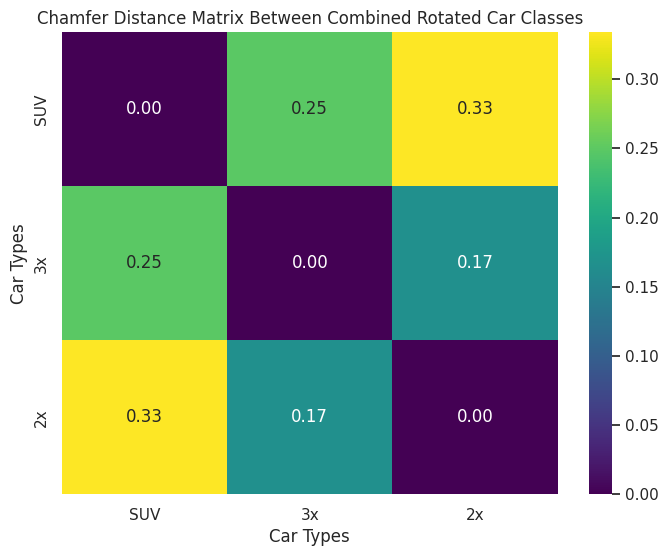

In [6]:
from scipy.spatial.transform import Rotation as R

def rotate_point_cloud(pc, angle_degrees, axis='z'):
    angle_radians = np.deg2rad(angle_degrees)
    rotation_matrix = R.from_euler(axis, angle_radians).as_matrix()
    return np.dot(pc, rotation_matrix[:3, :3].T)

# Rotate each point cloud by 1 degree increments and combine
combined_point_clouds = []
for pc in point_clouds:
    full_rotation_pc = np.concatenate([rotate_point_cloud(pc, angle) for angle in range(0,270,90)], axis=0)
    combined_point_clouds.append(full_rotation_pc)

# Calculate Chamfer distances between each pair of combined point clouds
distances = np.zeros((len(combined_point_clouds), len(combined_point_clouds)))
for i in range(len(combined_point_clouds)):
    for j in range(len(combined_point_clouds)):
        if i != j:
            distances[i, j] = chamfer_distance(combined_point_clouds[i], combined_point_clouds[j])
        else:
            distances[i, j] = 0  # Distance with itself is 0

# Plotting the Chamfer distances matrix using a heatmap
sns.set(style="white")
plt.figure(figsize=(8, 6))
ax = sns.heatmap(distances, annot=True, fmt=".2f", cmap="viridis", xticklabels=car_types, yticklabels=car_types)
plt.title('Chamfer Distance Matrix Between Combined Rotated Car Classes')
plt.xlabel('Car Types')
plt.ylabel('Car Types')
plt.show()

After rotating each model about the Z axis and appending the points, we get a lower difference between each class, this is likely due to higher point densities result in a decrease in score since the chamfer distance compares distances to nearest points. A high amount of points distributed equally increases the probability of a lower distance for the closest point

Will reducting the number of points increase the distance?

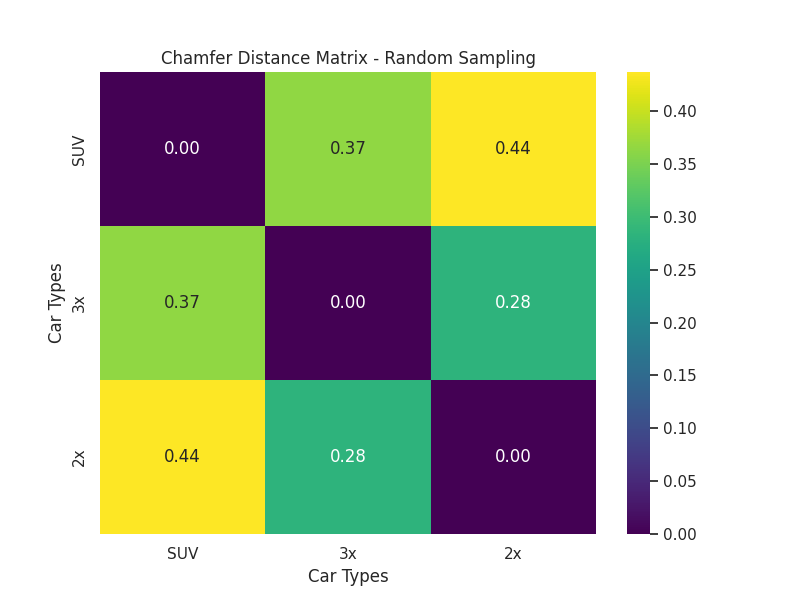

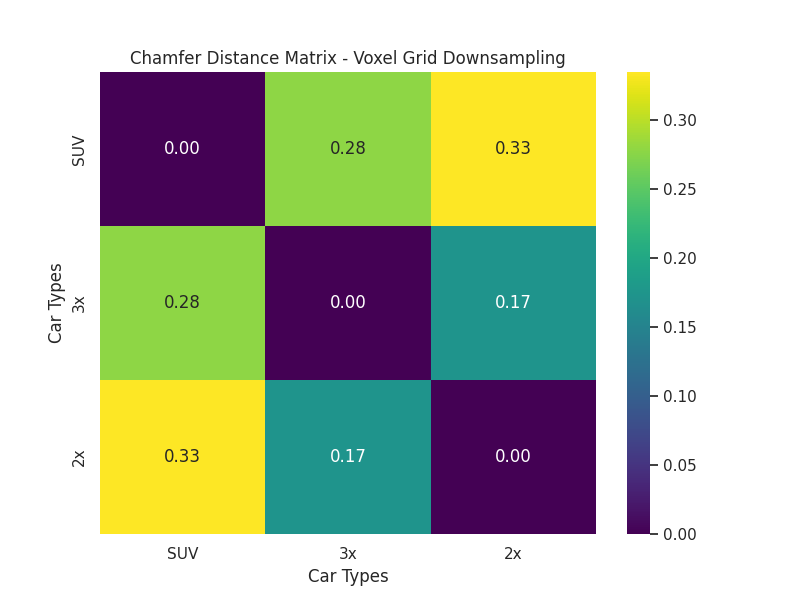

In [18]:
def random_sampling(point_cloud, num_samples):
    if num_samples > len(point_cloud):
        return point_cloud
    indices = np.random.choice(len(point_cloud), num_samples, replace=False)
    return point_cloud[indices]

def voxel_grid_downsampling(point_cloud, voxel_size):
    voxel_dict = {}
    for point in point_cloud:
        voxel_key = tuple((point // voxel_size).astype(int))
        if voxel_key not in voxel_dict:
            voxel_dict[voxel_key] = []
        voxel_dict[voxel_key].append(point)
    
    reduced_point_cloud = [np.mean(points, axis=0) for points in voxel_dict.values()]
    return np.array(reduced_point_cloud)

num_samples = 1000
voxel_size = np.array([0.1, 0.1, 0.1])  # Voxel size for downsampling

sampled_point_clouds_random = [random_sampling(pc, num_samples) for pc in combined_point_clouds]
sampled_point_clouds_voxel = [voxel_grid_downsampling(pc, voxel_size) for pc in combined_point_clouds]

def compute_distance_matrix(point_clouds):
    num_clouds = len(point_clouds)
    distances = np.zeros((num_clouds, num_clouds))
    for i in range(num_clouds):
        for j in range(num_clouds):
            if i != j:
                distances[i, j] = chamfer_distance(point_clouds[i], point_clouds[j])
            else:
                distances[i, j] = 0
    return distances

distances_random = compute_distance_matrix(sampled_point_clouds_random)
distances_voxel = compute_distance_matrix(sampled_point_clouds_voxel)

def plot_heatmap(distances, title,ticklabels=car_types,xlabel='Car Types',ylabel='Car Types'):
    sns.set(style="white")
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(distances, annot=True, fmt=".2f", cmap="viridis", xticklabels=ticklabels, yticklabels=ticklabels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_heatmap(distances_random, 'Chamfer Distance Matrix - Random Sampling')
plot_heatmap(distances_voxel, 'Chamfer Distance Matrix - Voxel Grid Downsampling')

In [19]:
def load_obj(filename):
    vertices = []  # List to store vertex positions

    # Open the file
    with open(filename, 'r') as file:
        # Iterate over each line
        for line in file:
            # Split the line into components
            parts = line.strip().split()
            # Check if this line describes a vertex
            if not parts or parts[0] != 'v':
                continue
            # Convert the vertex components to floats and add to the list
            vertex = tuple(map(float, parts[1:4]))  # Assumes vertex has x, y, z coordinates
            vertices.append(vertex)
                
    return vertices

In [20]:
person_pc_list = load_obj("/workspace/data/FinalBaseMesh.obj")
bike_pc_list = load_obj("/workspace/data/11717_bicycle_v2_L1.obj")

/workspace/examples/../utils/utils3d_model.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


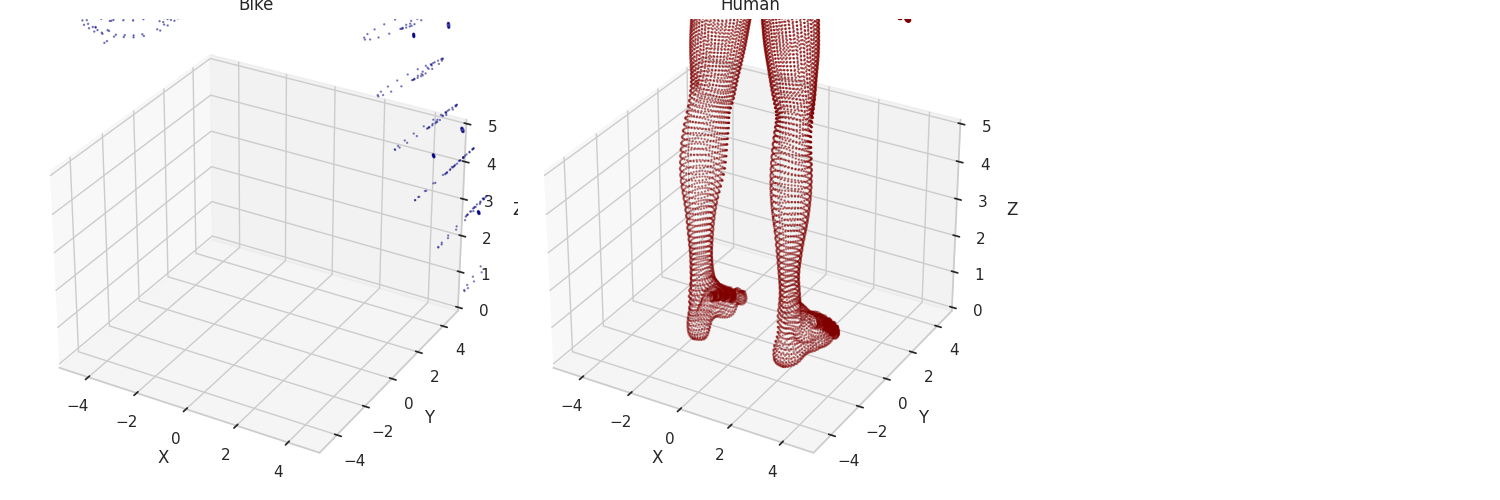

In [21]:
vertices_bike = np.array(bike_pc_list)
vertices_human = np.array(person_pc_list)

#transpose human to stand upright
vertices_human = vertices_human[:,[0,2,1]]

display_point_clouds([vertices_bike, vertices_human], ['Bike', 'Human'])

Note that bike and human are not scaled properly

In [22]:
#drandom sample person and bike
num_samples = 4000

sampled_person = random_sampling(vertices_human, num_samples)
sampled_bike = random_sampling(vertices_bike, num_samples)

#show person,car, and one of each car from front view
point_cloud_list["bike"] = [sampled_bike]
point_cloud_titles["bike"] = ["Bike"]
point_cloud_list["person"] = [sampled_person]
point_cloud_titles["person"] = ["Person"]



#print point cloud length for first of each type
print("Person: ", len(point_cloud_list["person"][0]))
print("Bike: ", len(point_cloud_list["bike"][0]))
print("SUV: ", len(point_cloud_list["SUV"][0]))
print("3x: ", len(point_cloud_list["3x"][0]))
print("2x: ", len(point_cloud_list["2x"][0]))



Person:  4000
Bike:  4000
SUV:  4294
3x:  4646
2x:  3644


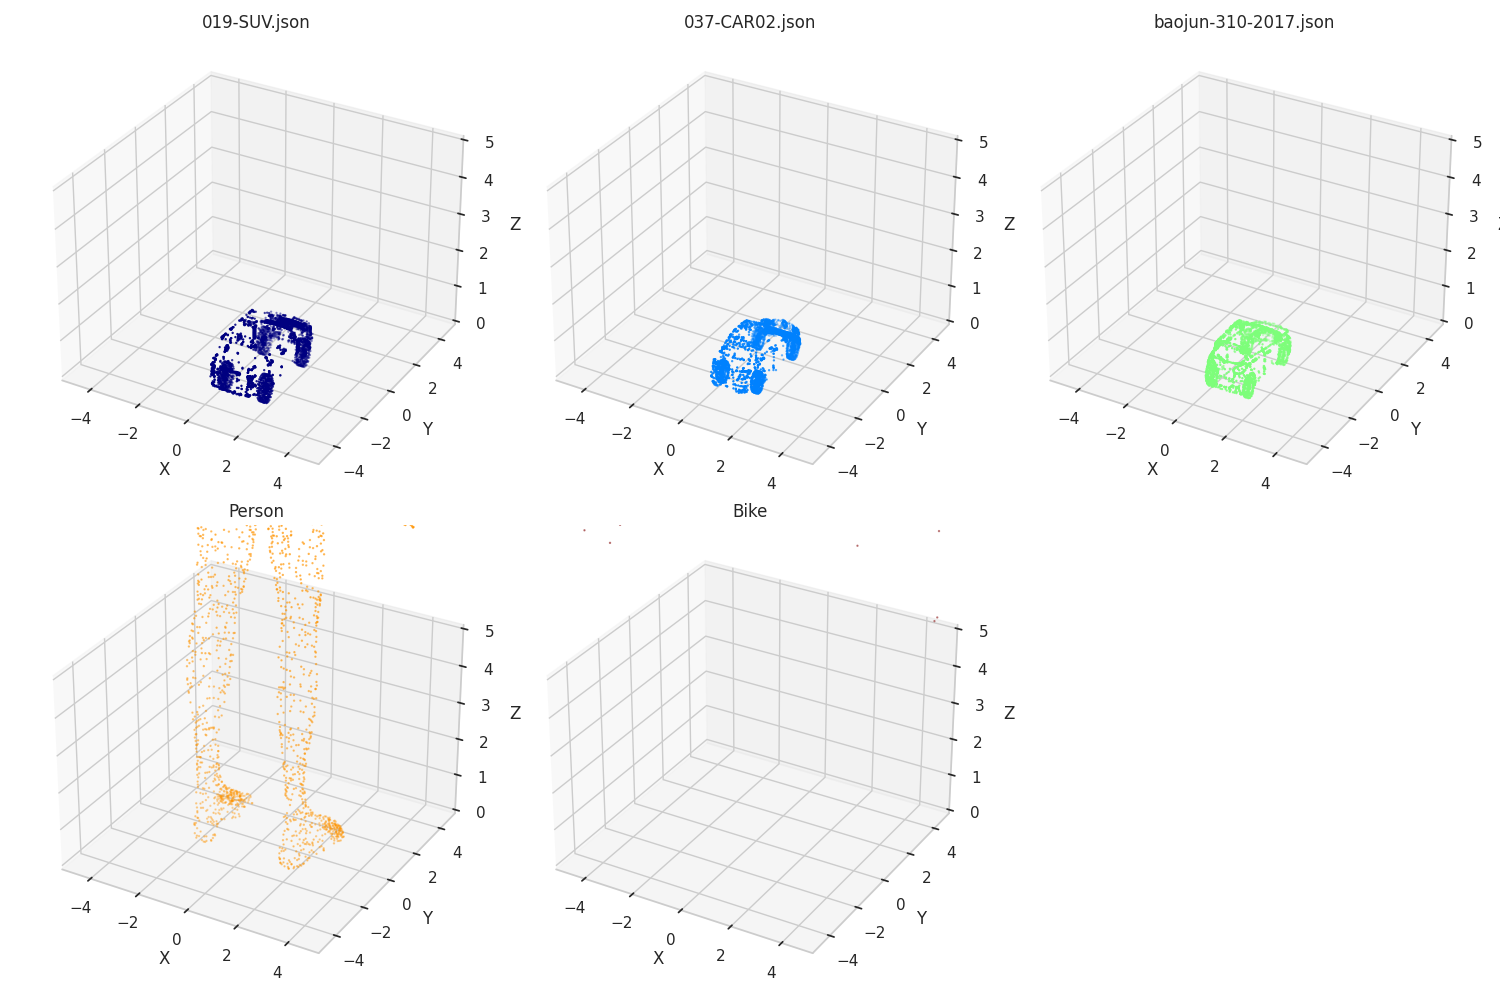

In [23]:
#plot one of each point cloud from front view
display_point_clouds([point_cloud_list["SUV"][0],point_cloud_list["3x"][0],point_cloud_list["2x"][0],point_cloud_list["person"][0],point_cloud_list["bike"][0]], [point_cloud_titles["SUV"][0],point_cloud_titles["3x"][0],point_cloud_titles["2x"][0],point_cloud_titles["person"][0],point_cloud_titles["bike"][0]])

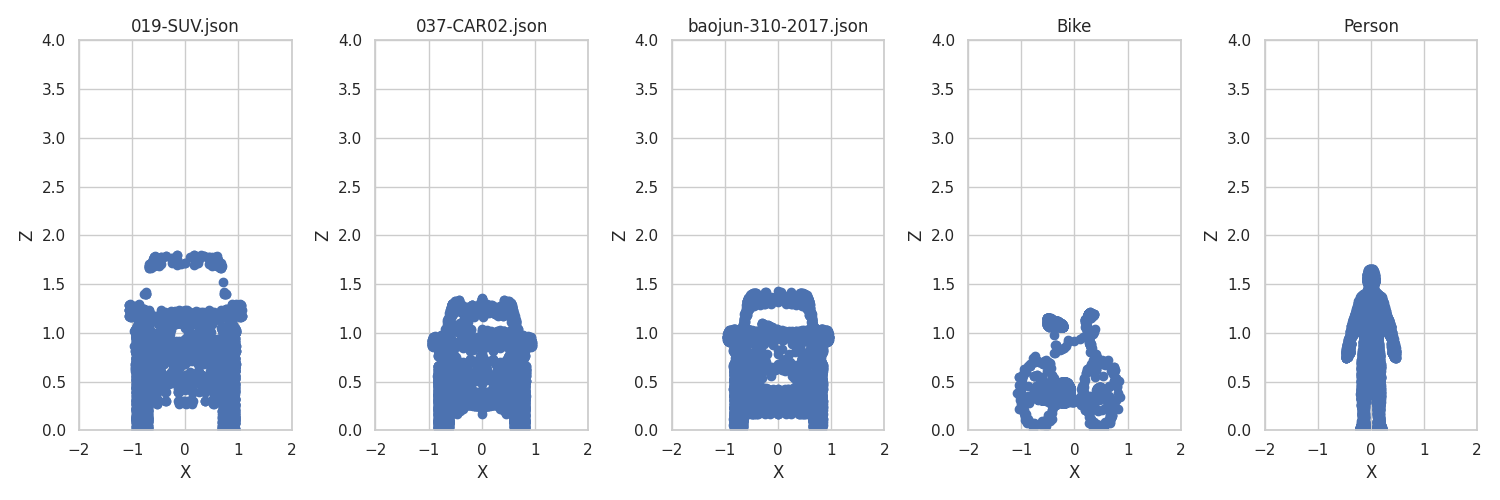

In [24]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

def scale_point_clouds(point_clouds, scale_factors):
    scaled_point_clouds = []
    for i, pc in enumerate(point_clouds):
        scaled_pc = pc * scale_factors[i]
        scaled_point_clouds.append(scaled_pc)
    return scaled_point_clouds

def display_point_clouds_XY_proj(point_clouds, titles):
    fig, axes = plt.subplots(1, len(point_clouds), figsize=(15, 5))
    if len(point_clouds) == 1:
        axes = [axes]  # make it iterable if only one ax is present
    for ax, point_cloud, title in zip(axes, point_clouds, titles):
        ax.scatter(point_cloud[:, 0], point_cloud[:, 2])  # Plot X and Z dimensions
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_title(title)

        # Set limits for the axes
        ax.set_xlim(-2, 2)
        ax.set_ylim(-0, 4)


    plt.tight_layout()
    plt.show()

def translate_point_clouds(point_clouds):
    translated_point_clouds = []
    for pc in point_clouds:
        min_z = np.min(pc[:, 2])
        if min_z < 0:
            translation_vector = np.array([0, 0, -min_z])
            translated_pc = pc + translation_vector
        else:
            translated_pc = pc
        translated_point_clouds.append(translated_pc)
    return translated_point_clouds

# Scale factors for each object
scale_factors = [1, 1, 1, 0.03, 0.08]

# Select one point cloud from each category and scale it
selected_point_clouds = [point_cloud_list[key][0] for key in point_cloud_list]
scaled_point_clouds = scale_point_clouds(selected_point_clouds, scale_factors)
translated_point_clouds = translate_point_clouds(scaled_point_clouds)
# Display the scaled 2D projections of the selected point clouds
display_point_clouds_XY_proj(translated_point_clouds, [point_cloud_titles[key][0] for key in point_cloud_titles])




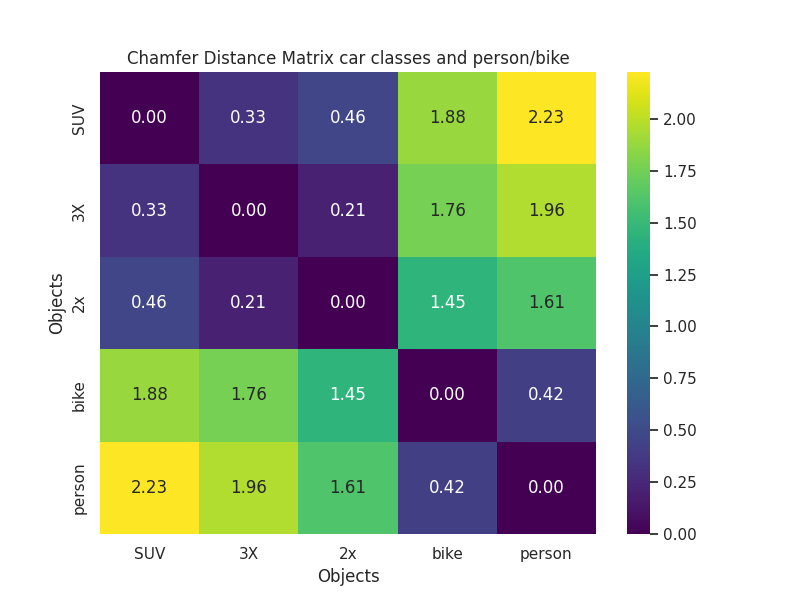

In [27]:
#get headmap of trnaslated point clouds
distances = compute_distance_matrix(translated_point_clouds)

# Plotting the Chamfer distances matrix using a heatmap with new titles
plot_heatmap(distances, 'Chamfer Distance Matrix car classes and person/bike',ticklabels=["SUV","3X","2x","bike","person"],xlabel='Objects',ylabel='Objects')

Notice the defined distances between different class

In [36]:
import open3d as o3d
def load_obj(filepath):
    # Load the mesh
    mesh = o3d.io.read_triangle_mesh(filepath)
    return np.asarray(mesh.vertices)
vertices_synth_mesh = load_obj("/workspace/data/baojun-310.obj")
vertices_synth = np.array(vertices_synth_mesh)
print(vertices_synth.shape)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(21964, 3)


/workspace/examples/../utils/utils3d_model.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


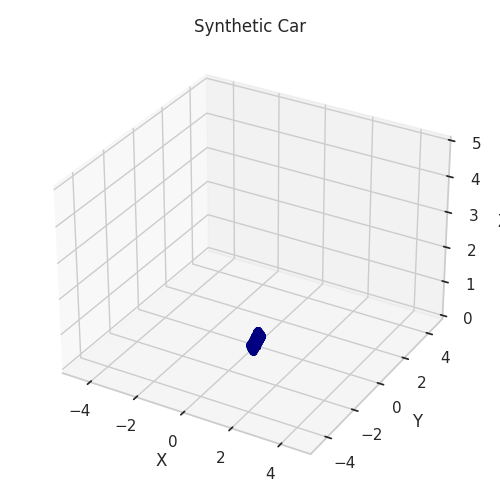

In [51]:

display_point_clouds([sampled_synth], ['Synthetic Car'],num_cols=1)

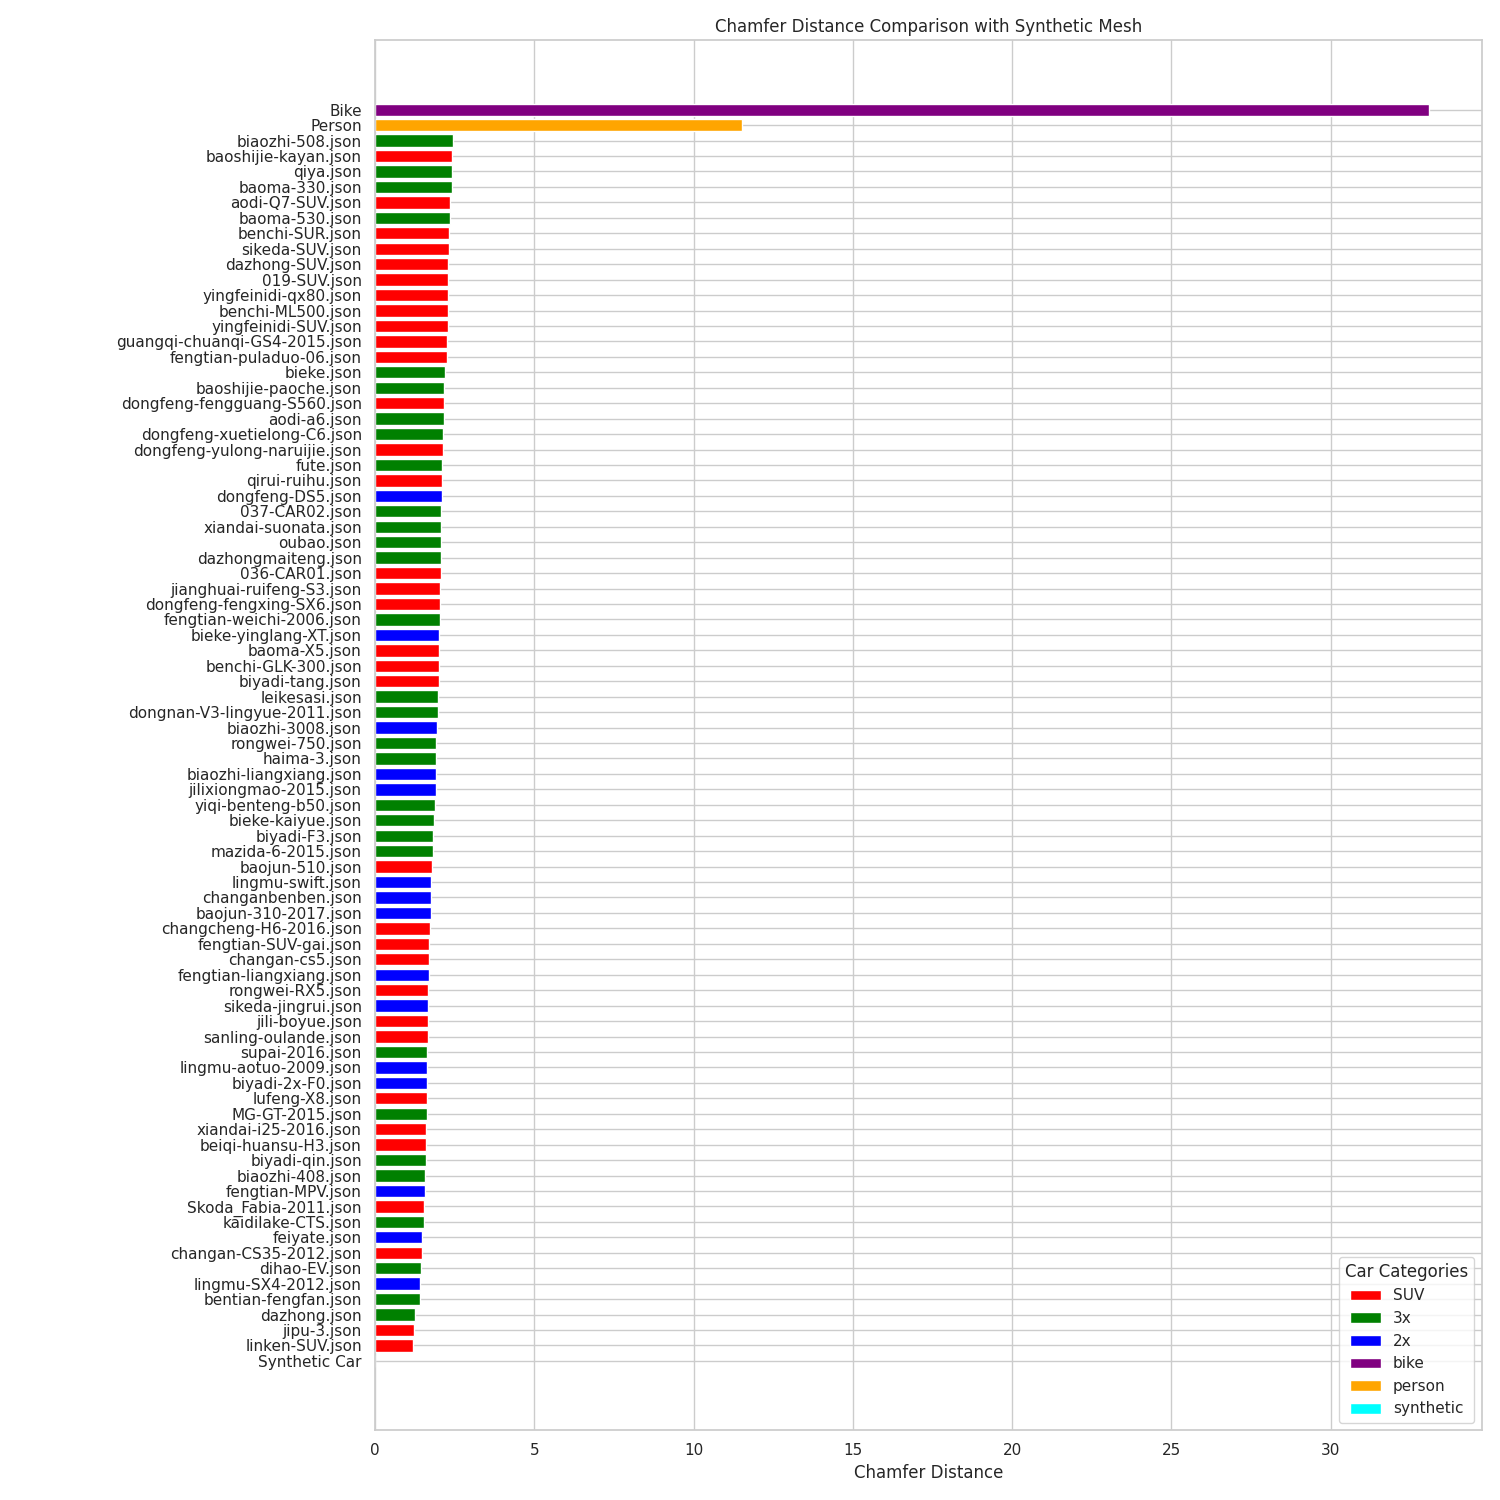

In [50]:
#downsample synthetic meshese
num_samples = 4000
sampled_synth = random_sampling(vertices_synth, num_samples)
point_cloud_list["synthetic"] = [sampled_synth]
point_cloud_titles["synthetic"] = ["Synthetic Car"]

# Define a dictionary to map categories to colors
category_colors = {
    "SUV": "red",
    "3x": "green",
    "2x": "blue",
    "bike": "purple",
    "person": "orange",
    "synthetic": "cyan"
}

# Compute Chamfer distances
chamfer_distances = []
labels = []
colors = []  # List to store colors for the bars

for category in point_cloud_list:
    for pc, title in zip(point_cloud_list[category], point_cloud_titles[category]):
        distance = chamfer_distance(sampled_synth, pc)
        chamfer_distances.append(distance)
        labels.append(title)
        colors.append(category_colors[category])  # Assign color based on category

# Sort distances and corresponding labels and colors
sorted_indices = np.argsort(chamfer_distances)
sorted_distances = np.array(chamfer_distances)[sorted_indices]
sorted_labels = np.array(labels)[sorted_indices]
sorted_colors = np.array(colors)[sorted_indices]

# Plotting
plt.figure(figsize=(15,15))
bars = plt.barh(sorted_labels, sorted_distances, color=sorted_colors)
plt.xlabel('Chamfer Distance')
plt.title('Chamfer Distance Comparison with Synthetic Mesh')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=category_colors[key], label=key) for key in category_colors]
plt.legend(handles=legend_elements, title="Car Categories")

# Improve layout and label spacing
plt.tight_layout()
plt.subplots_adjust(left=0.25)  # Adjust this value based on your actual labels to avoid clipping

plt.show()

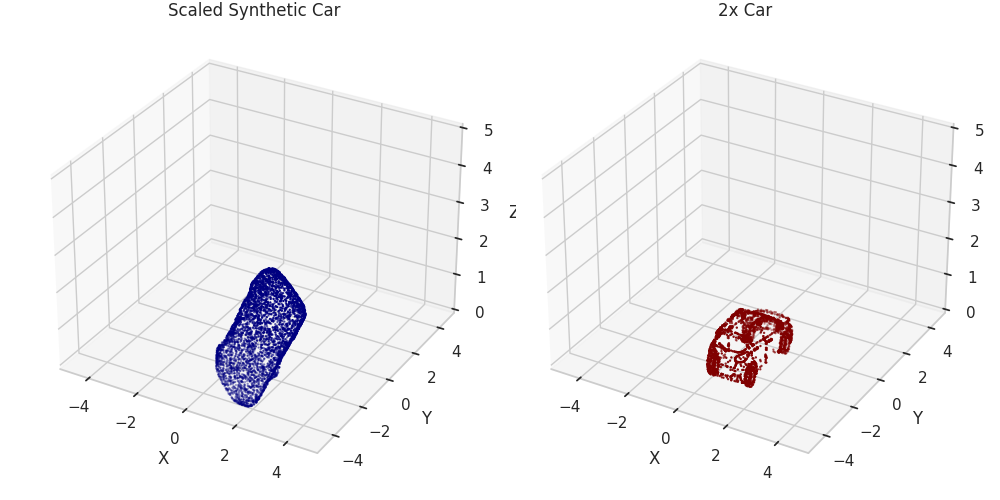

In [53]:

def compute_bounding_sphere(points):
    # Calculate the geometric center of the points
    center = np.mean(points, axis=0)
    # Calculate the radius as the maximum distance from the center to any point
    radius = np.max(np.linalg.norm(points - center, axis=1))
    return center, radius

def scale_mesh(points, target_radius, source_radius):
    # Calculate the scale factor
    scale_factor = target_radius / source_radius
    # Scale the points
    center = np.mean(points, axis=0)
    scaled_points = (points - center) * scale_factor + center
    return scaled_points

# Assuming vertices_synth and a target point cloud are numpy arrays
source_points = sampled_synth
target_points = point_cloud_list["2x"][0]

# Compute bounding spheres
_, source_radius = compute_bounding_sphere(source_points)
_, target_radius = compute_bounding_sphere(target_points)

# Scale the source point cloud to the size of the target point cloud
scaled_points = scale_mesh(source_points, target_radius, source_radius)

display_point_clouds([scaled_points, target_points], ['Scaled Synthetic Car', '2x Car'],num_cols=2)

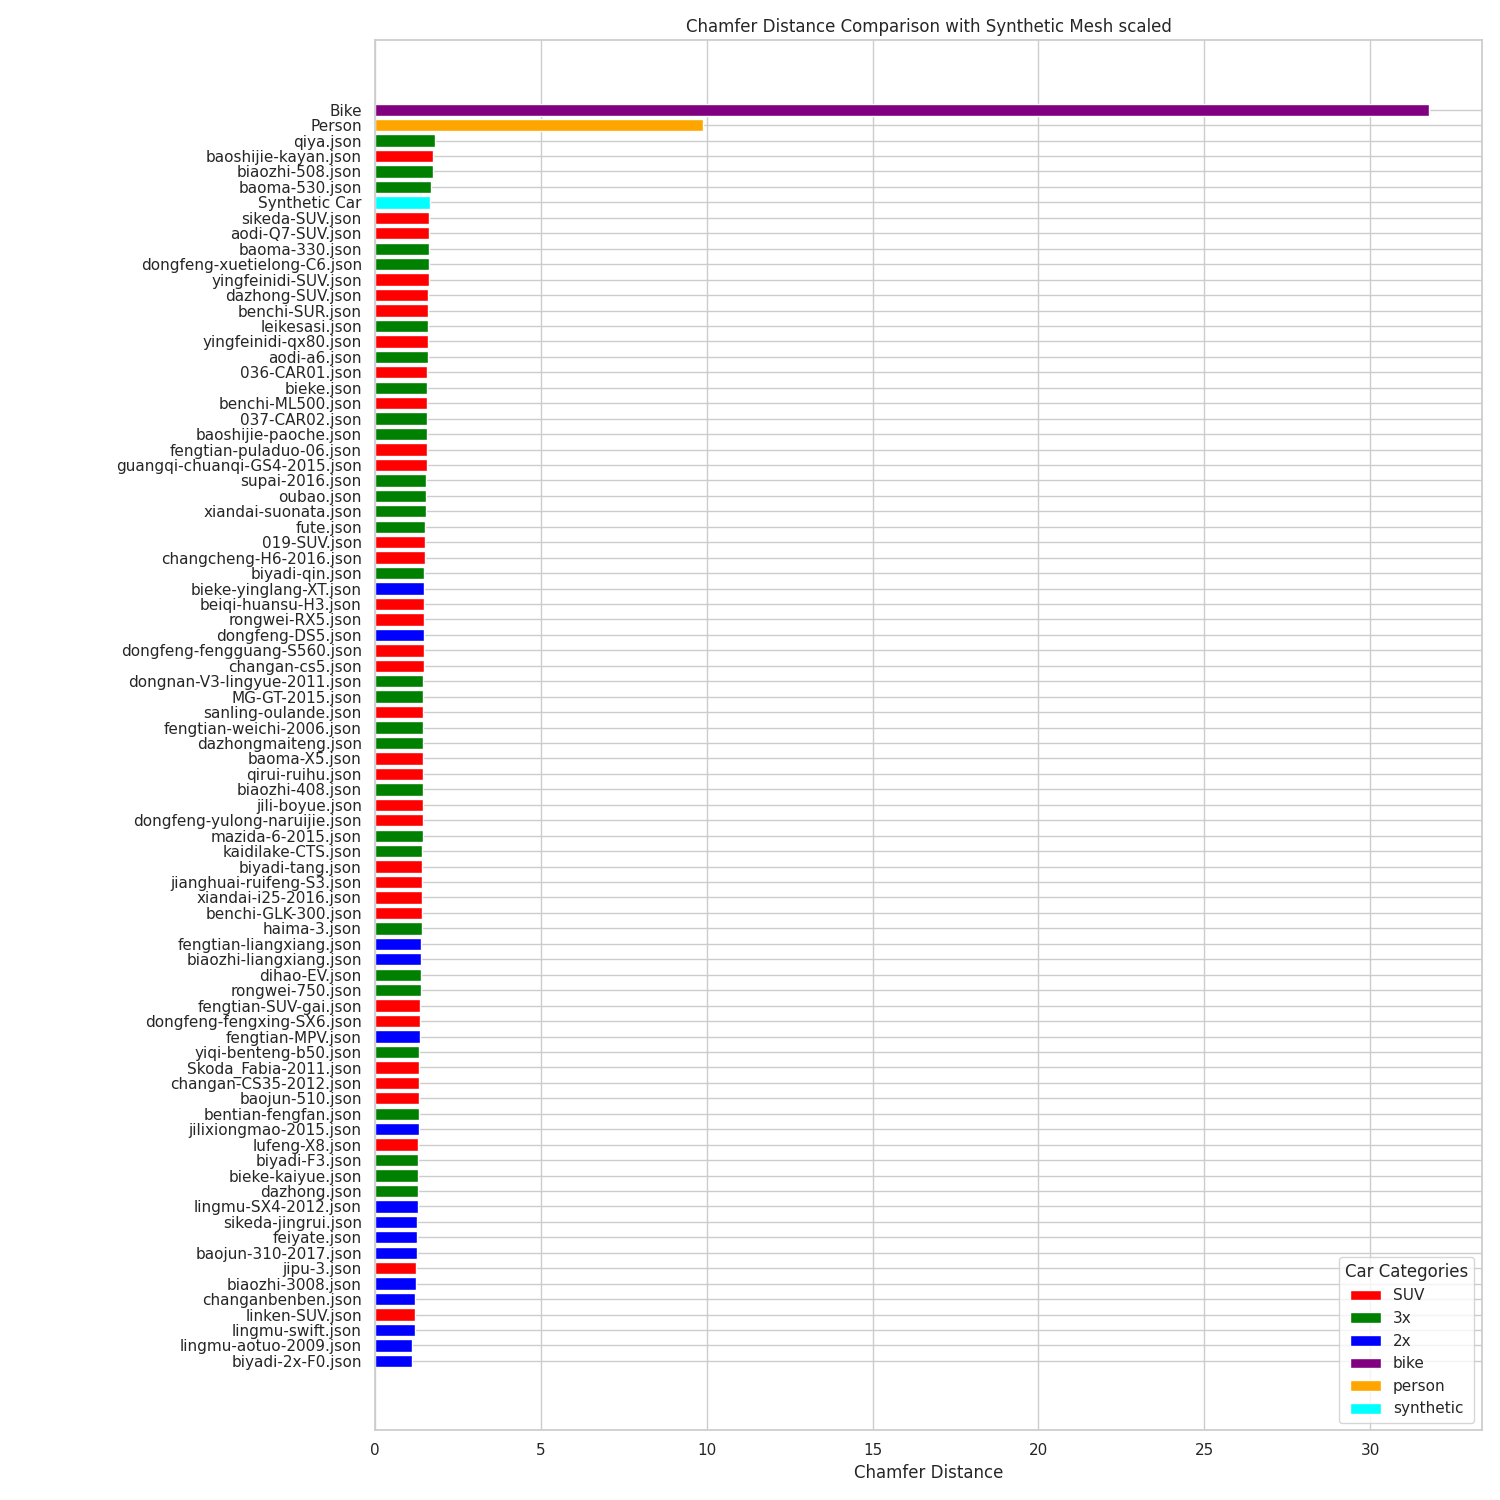

In [54]:
# Compute Chamfer distances
chamfer_distances = []
labels = []
colors = []  # List to store colors for the bars

for category in point_cloud_list:
    for pc, title in zip(point_cloud_list[category], point_cloud_titles[category]):
        distance = chamfer_distance(scaled_points, pc)
        chamfer_distances.append(distance)
        labels.append(title)
        colors.append(category_colors[category])  # Assign color based on category

# Sort distances and corresponding labels and colors
sorted_indices = np.argsort(chamfer_distances)
sorted_distances = np.array(chamfer_distances)[sorted_indices]
sorted_labels = np.array(labels)[sorted_indices]
sorted_colors = np.array(colors)[sorted_indices]

# Plotting
plt.figure(figsize=(15,15))
bars = plt.barh(sorted_labels, sorted_distances, color=sorted_colors)
plt.xlabel('Chamfer Distance')
plt.title('Chamfer Distance Comparison with Synthetic Mesh scaled')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=category_colors[key], label=key) for key in category_colors]
plt.legend(handles=legend_elements, title="Car Categories")

# Improve layout and label spacing
plt.tight_layout()
plt.subplots_adjust(left=0.25)  # Adjust this value based on your actual labels to avoid clipping

plt.show()

/workspace/examples/../utils/utils3d_model.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


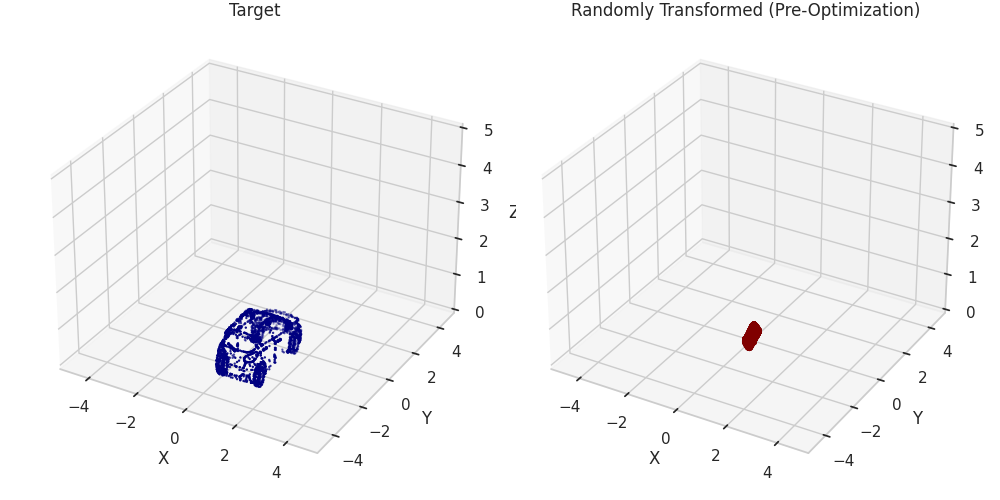

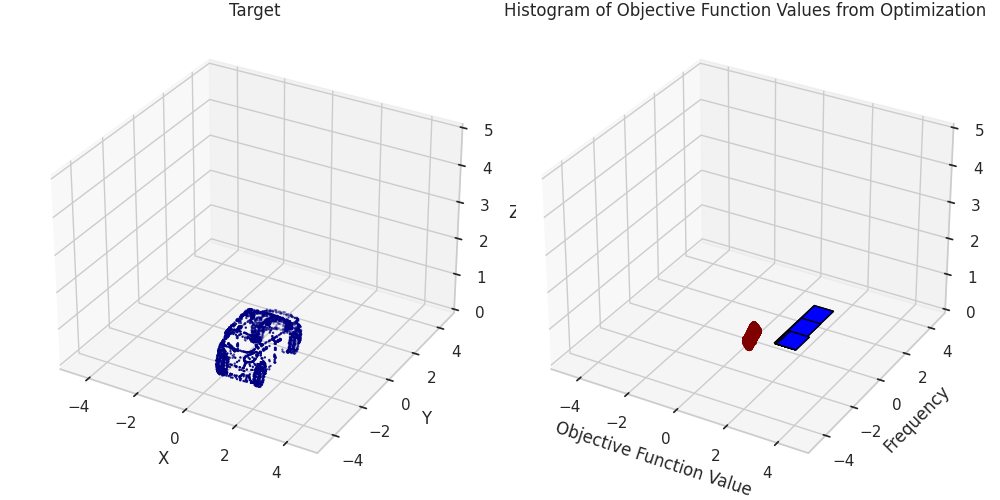

In [55]:
#find transformation to minimize chamfer distance
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize

def transform_point_cloud_numpy(pc, transformation_matrix):
    # Add a column of ones to the point cloud to handle translations (homogeneous coordinates)
    homogeneous_pc = np.hstack([pc, np.ones((pc.shape[0], 1))])
    # Apply the transformation matrix to the point cloud
    transformed_homogeneous_pc = homogeneous_pc.dot(transformation_matrix.T)
    # Return only the x, y, z coordinates, not the homogeneous coordinate
    return transformed_homogeneous_pc[:, :3]

def build_transformation_matrix(rotation_vector, translation_vector):
    rotation_matrix = R.from_rotvec(rotation_vector).as_matrix()
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation_vector
    return transformation_matrix

reference_pc = point_cloud_list['2x'][0].copy()  # Reference point cloud
initial_pc = sampled_synth.copy()
display_point_clouds([reference_pc, initial_pc], ['Target', 'Randomly Transformed (Pre-Optimization)'], num_cols=2)

def objective_function(transformation_vector, initial_pc=initial_pc, reference_pc=reference_pc):
    """Objective function that optimizes both rotation and translation."""
    transformation_matrix = build_transformation_matrix(transformation_vector[:3], transformation_vector[3:])
    transformed_pc = transform_point_cloud_numpy(initial_pc, transformation_matrix)
    loss = chamfer_distance(transformed_pc, reference_pc)
    return loss


results = []
for _ in range(10):
    initial_params = np.random.uniform(-np.pi, np.pi, 6)  # Random initialization
    bounds = [(-np.pi, np.pi)] * 3 + [(-5, 5)] * 3  # Set bounds for each parameter
    result = minimize(objective_function, initial_params, args=(initial_pc, reference_pc),
                      bounds=bounds, method='L-BFGS-B')
    results.append(result.fun)



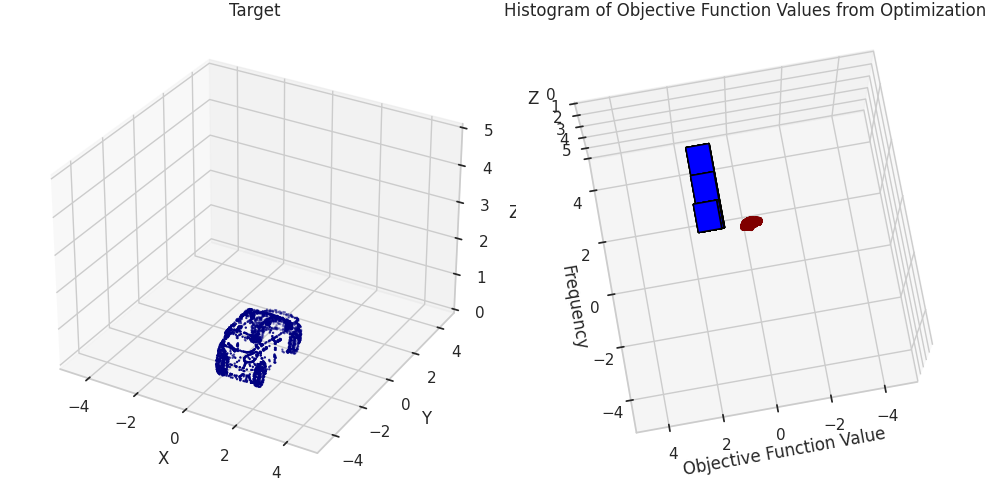

(10,)

In [59]:
np.array(results).shape
# Plotting the histogram of the optimization results
plt.hist(np.array(results), bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Objective Function Values from Optimization')
plt.xlabel('Objective Function Value')
plt.ylabel('Frequency')
plt.show()

np.array(results).shape

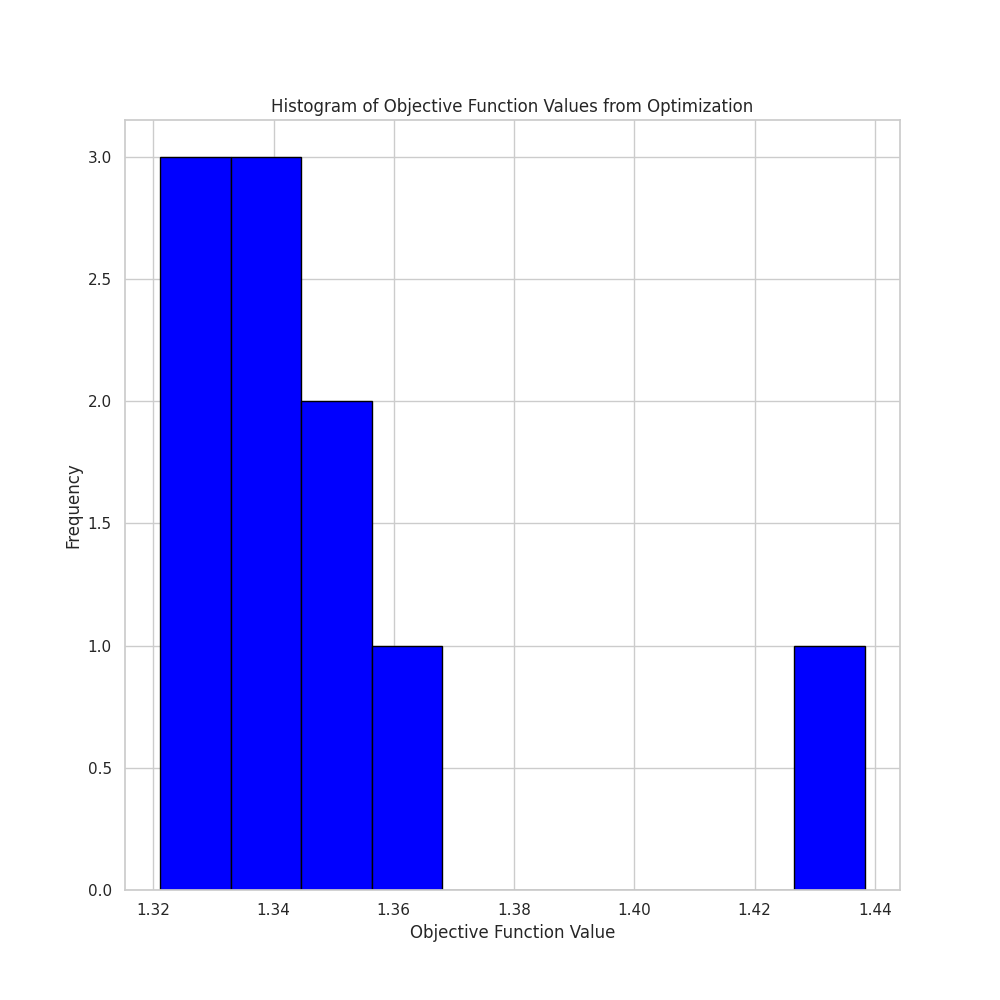

(10,)

In [62]:
#clear plt
plt.clf()
plt.figure(figsize=(10,10))
# Plotting the histogram of the optimization results
plt.hist(np.array(results), bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Objective Function Values from Optimization')
plt.xlabel('Objective Function Value')
plt.ylabel('Frequency')
plt.show()

np.array(results).shape